### Information about the different models which might be useful when writing the paper
C-RADIOv2 models are available in multiple sizes: Base (90M parameters). Huge (653M parameters). C-RADIOv2 was trained for 1M steps (400k more steps than v1), using inverse frequency sampling for data balancing, and PHI Standardization for teacher distribution balancing. 

Model Architecture
Architecture Type: Neural Network
Network Architecture: Vision Transformer

c-radio-h	ViT-H/16-CPE https://github.com/NVlabs/RADIO

In [8]:
# setup

import pandas as pd
import matplotlib.pyplot as plt
import string
import numpy as np

MODELS = {
    "dino_vitb16": "DINO ViT-B/16",
    "dinov2_vitb14": "DINOv2 ViT-B/14",
    "clip-vit-base-patch16": "CLIP ViT-B/16",
    "tips-b14" : "TIPS ViT-B/14-HR", # (448)
    "C-RADIOv2-B": "C-RADIOv2 ViT-B/16-CPE",
    "siglip2-base-patch16-512": "SigLIP 2 B/16-512",
}
COLORS = {
    "clip-vit-base-patch16": "#1f77b4",
    "dino_vitb16": "#ff7f0e",
    "dinov2_vitb14": "#2ca02c",
    "C-RADIOv2-B": "#d62728",
    "siglip2-base-patch16-512": "#9467bd",
    "tips-b14": "#8c564b",
}
TRAIN_BINS_DIFFICULTY = {
    "0_30_60_90": "easy",
    "0_45_90": "medium",
    "0_90": "hard",
    "0": "extreme"
}
XTICKS = [0, 15, 30, 45, 60, 75, 90]
CLASS_TO_INDEX = {
    0: 0,
    7: 1,
    8: 2,
    19: 3,
    46: 4,
    57: 5,
    60: 6,
    70: 7,
    99: 8,
    100: 9,
    113: 10,
    125: 11,
    126: 12,
    152: 13,
    166: 14,
    196: 15,
}
CLASS_TO_NAME = {
    0: "background",
    7: "stove",
    8: "sofa",
    19: "microwave",
    46: "bed",
    57: "toy cat",
    60: "toy cow",
    70: "toy dragon",
    99: "coat rack",
    100: "guitar stand",
    113: "ceiling lamp",
    125: "toilet",
    126: "sink",
    152: "strings",
    166: "broccoli",
    196: "durian"
}


# Experiment A

In [9]:
PATH = "../results/results_exp_a_500_sharding_batch4_workers8_dataparallel_memory1024000.csv"
DF = pd.read_csv(PATH)

DF

,job_id,model,train_bins,val_bin,jac_mean,jac_std,jac0,jac1,jac2,jac3,...,jac10,jac11,jac12,jac13,jac14,jac15,d_model,batch_size,input_size,patch_size
0,12081378,clip-vit-base-patch16,0_30_60_90,0,0.784,0.117,0.971,0.848,0.861,0.792,...,0.756,0.876,0.674,0.883,0.872,0.905,768,4,512,16
1,12081378,clip-vit-base-patch16,0_30_60_90,15,0.764,0.136,0.970,0.857,0.850,0.792,...,0.737,0.885,0.578,0.886,0.859,0.898,768,4,512,16
2,12081378,clip-vit-base-patch16,0_30_60_90,30,0.793,0.111,0.973,0.877,0.872,0.820,...,0.746,0.896,0.696,0.894,0.861,0.903,768,4,512,16
3,12081378,clip-vit-base-patch16,0_30_60_90,45,0.775,0.126,0.972,0.862,0.847,0.806,...,0.737,0.881,0.656,0.888,0.863,0.906,768,4,512,16
4,12081378,clip-vit-base-patch16,0_30_60_90,60,0.796,0.108,0.974,0.865,0.872,0.822,...,0.755,0.879,0.704,0.882,0.870,0.908,768,4,512,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,12081386,tips-b14,0,30,0.544,0.186,0.953,0.560,0.619,0.318,...,0.600,0.486,0.307,0.683,0.768,0.787,768,4,504,14
164,12081386,tips-b14,0,45,0.486,0.197,0.949,0.500,0.553,0.269,...,0.530,0.399,0.249,0.597,0.735,0.770,768,4,504,14
165,12081386,tips-b14,0,60,0.447,0.205,0.946,0.429,0.539,0.245,...,0.488,0.313,0.174,0.546,0.715,0.757,768,4,504,14
166,12081386,tips-b14,0,75,0.422,0.216,0.944,0.409,0.521,0.221,...,0.473,0.257,0.111,0.529,0.696,0.749,768,4,504,14


In [10]:
def plot_exp_a(classes: None | list[int], include_bg: bool, extratitle: str):
    """
    Plot experiment A result for specified class.
    Class is either None (all classes) or a list of class numbers
    """
    
    assert type(classes) in [list, type(None)], "classes must be a list or None"

    if classes is None:
        classes = list(CLASS_TO_INDEX.keys())
    else:
        assert all(c in CLASS_TO_INDEX for c in classes), "classes must be a subset of CLASS_TO_INDEX keys"

    if not include_bg:
        # remove background class (0) from classes
        classes = [c for c in classes if c != 0]
    
    class_indices = [CLASS_TO_INDEX[c] for c in classes]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=200)
    axes = axes.flatten()

    for i, (train_bins, difficulty) in enumerate(TRAIN_BINS_DIFFICULTY.items()):
        ax = axes[i]
        
        train_bins_set = set(map(int, train_bins.split("_")))
                
        for model in MODELS.keys():
            df = DF[DF["model"] == model]
            df = df[df["train_bins"] == train_bins].sort_values("val_bin")

            # only get the jacX values for classes X
            df["jac_mean"] = df[[f"jac{c}" for c in class_indices]].mean(axis=1)
            df["jac_std"] = df[[f"jac{c}" for c in class_indices]].std(axis=1)

            x_values = df["val_bin"]
            y_values = df["jac_mean"].values
            y_error = df["jac_std"].values

            if len(x_values) == 0 or len(y_values) == 0:
                print(f"No data for model {model} with train_bins {train_bins} and classes {classes}")
                continue

            # plot the data
            for j, (x_value, y_value) in enumerate(zip(x_values, y_values)):
                # Use asterisk marker if bin is trained on, circle for others
                marker = 'x' if int(x_value) in train_bins_set else 'o'
                ax.scatter(x_value, y_value, label=f"{MODELS[model]}" if j == 1 else "", 
                           color=COLORS[model], marker=marker, s=50, zorder=2)

            # include error bars
            ax.errorbar(x_values, y_values, yerr=y_error, fmt='none', color=COLORS[model], 
                        capsize=5, elinewidth=0)
            
        ax.set_xticks(XTICKS)
        ax.set_ylim(0, 1)
        ax.set_title(f"({string.ascii_letters[i]}) Training bin(s) = {', '.join(train_bins.split('_'))} ({difficulty})")
        # ax.set_title(f"Extreme difficulty, class: ceiling lamp", fontsize=10)
        ax.set_xlabel("Bin")
        ax.set_ylabel("mIoU")
        ax.grid(True)

    axes[0].legend()
    # plt.suptitle(f"Experiment A results ({extratitle})", fontsize=14)
    plt.tight_layout()
    plt.show()


## Plots

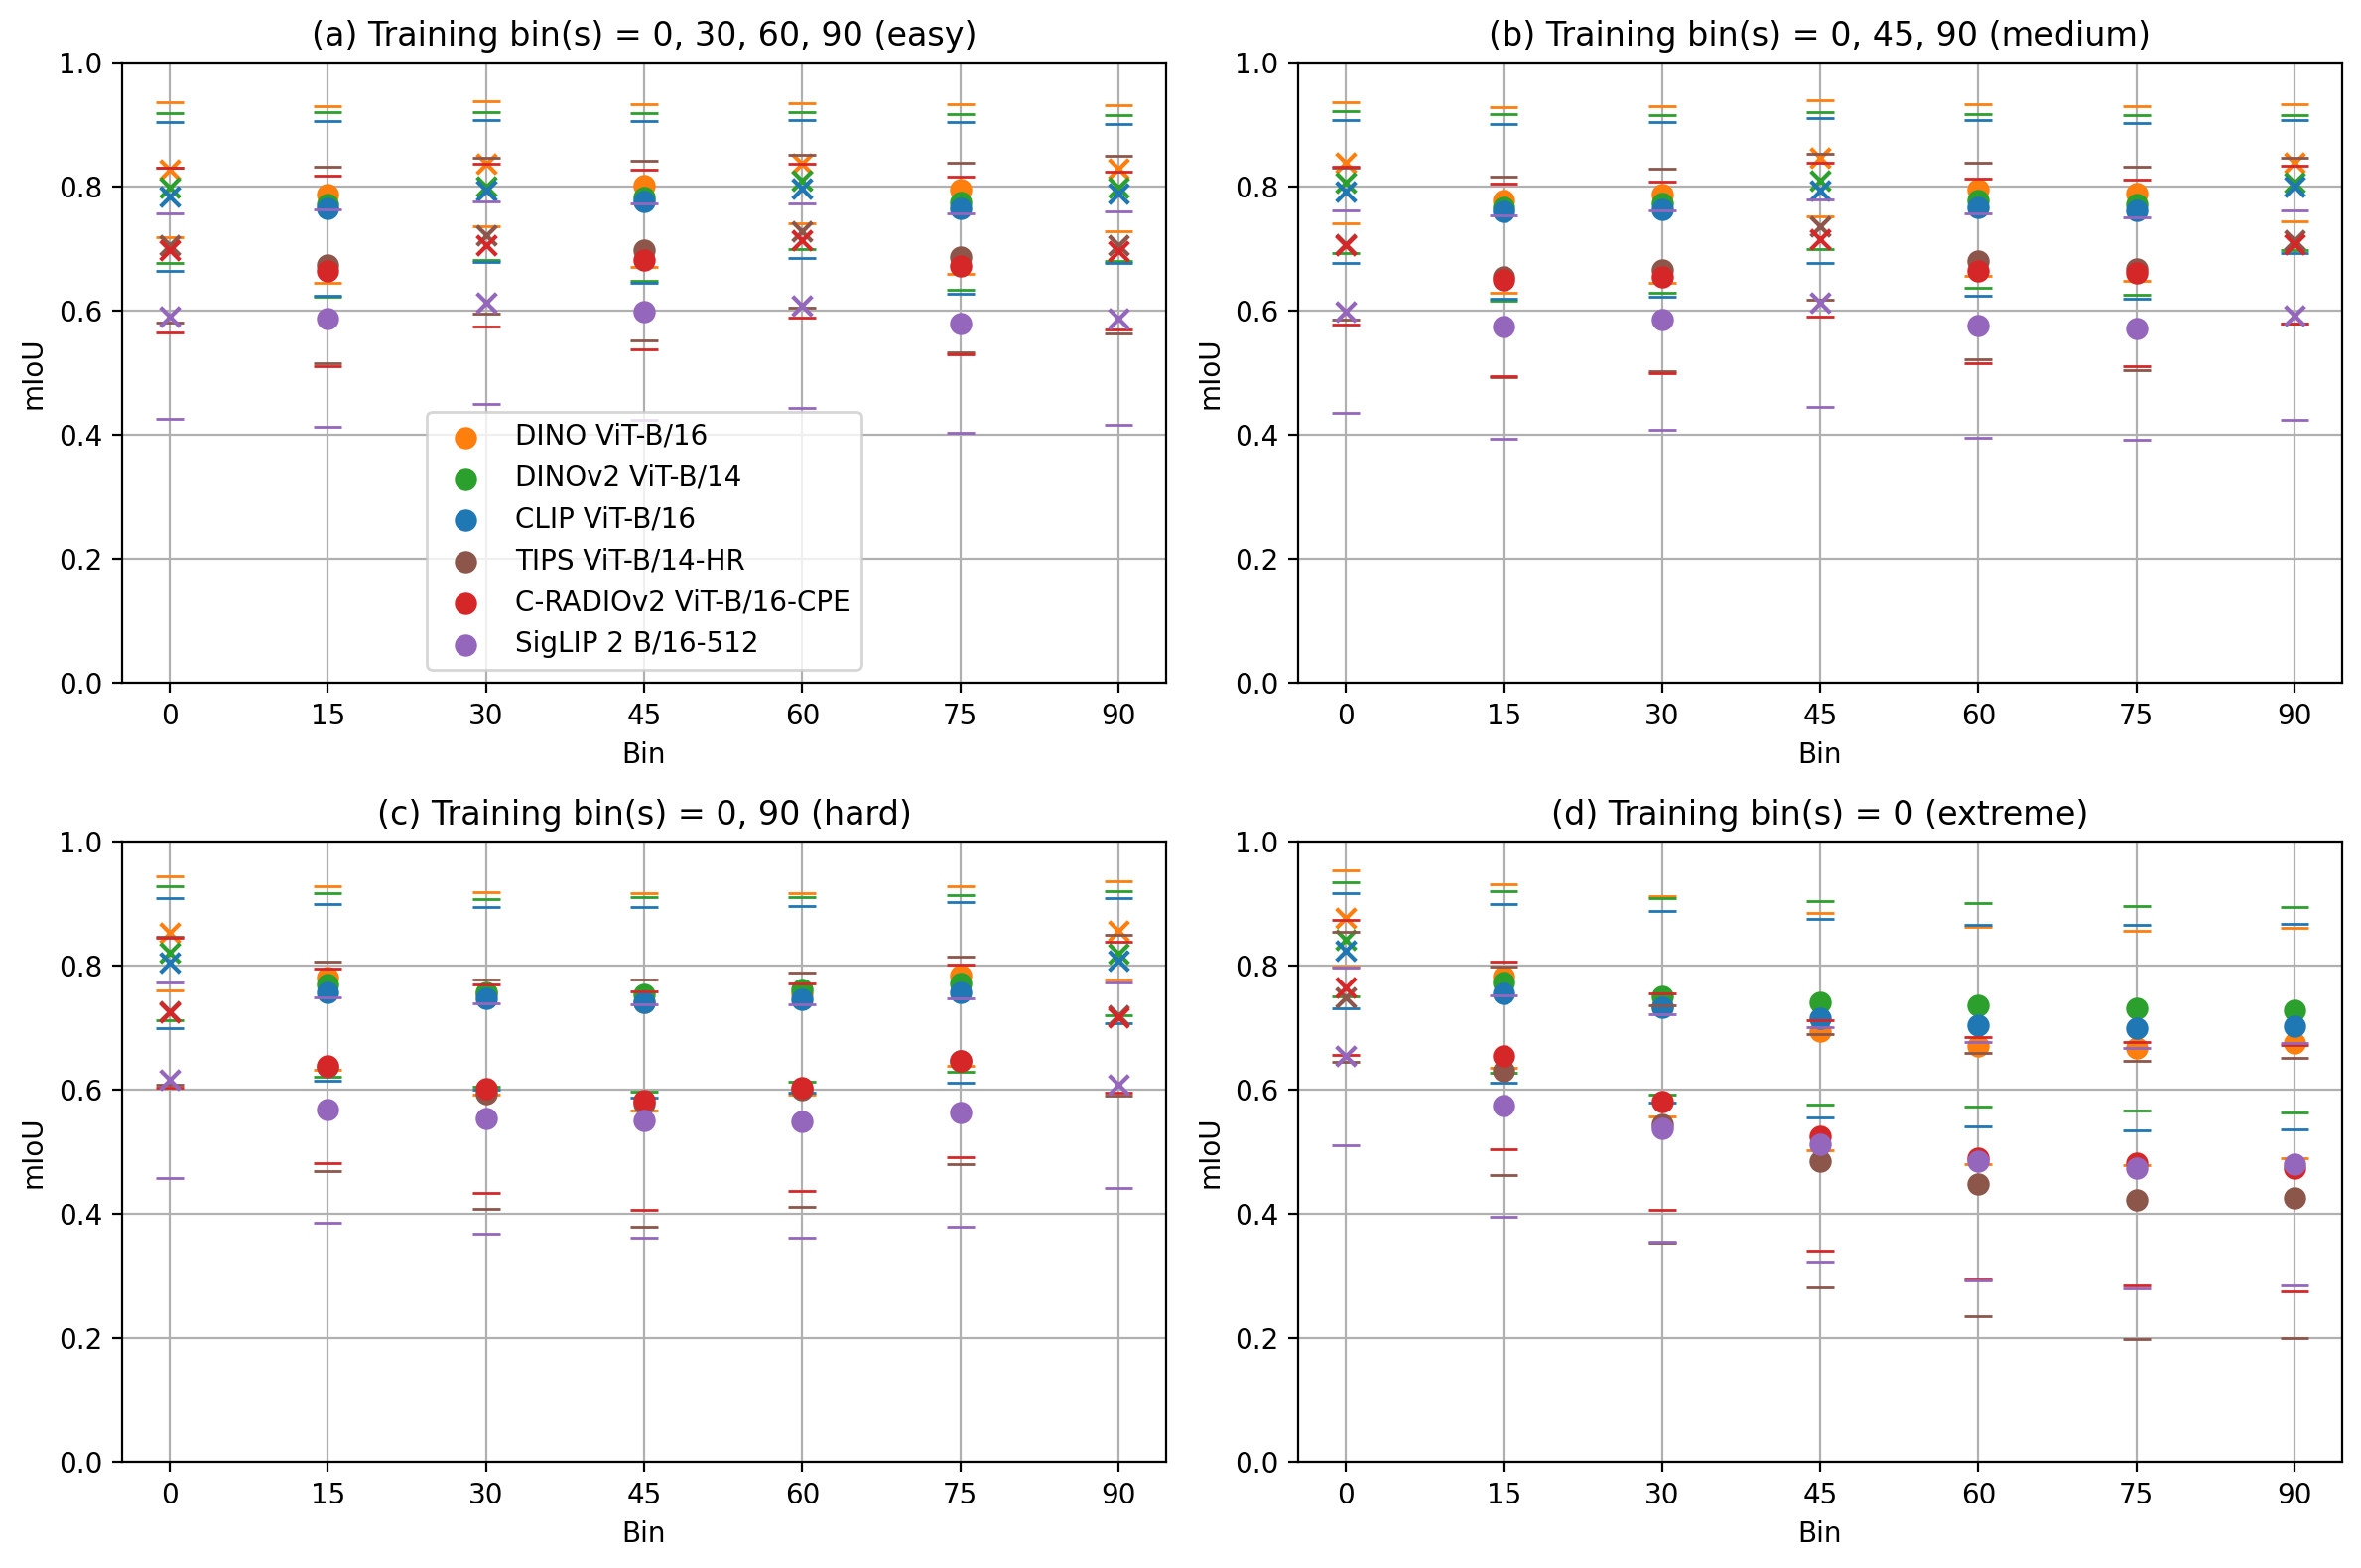

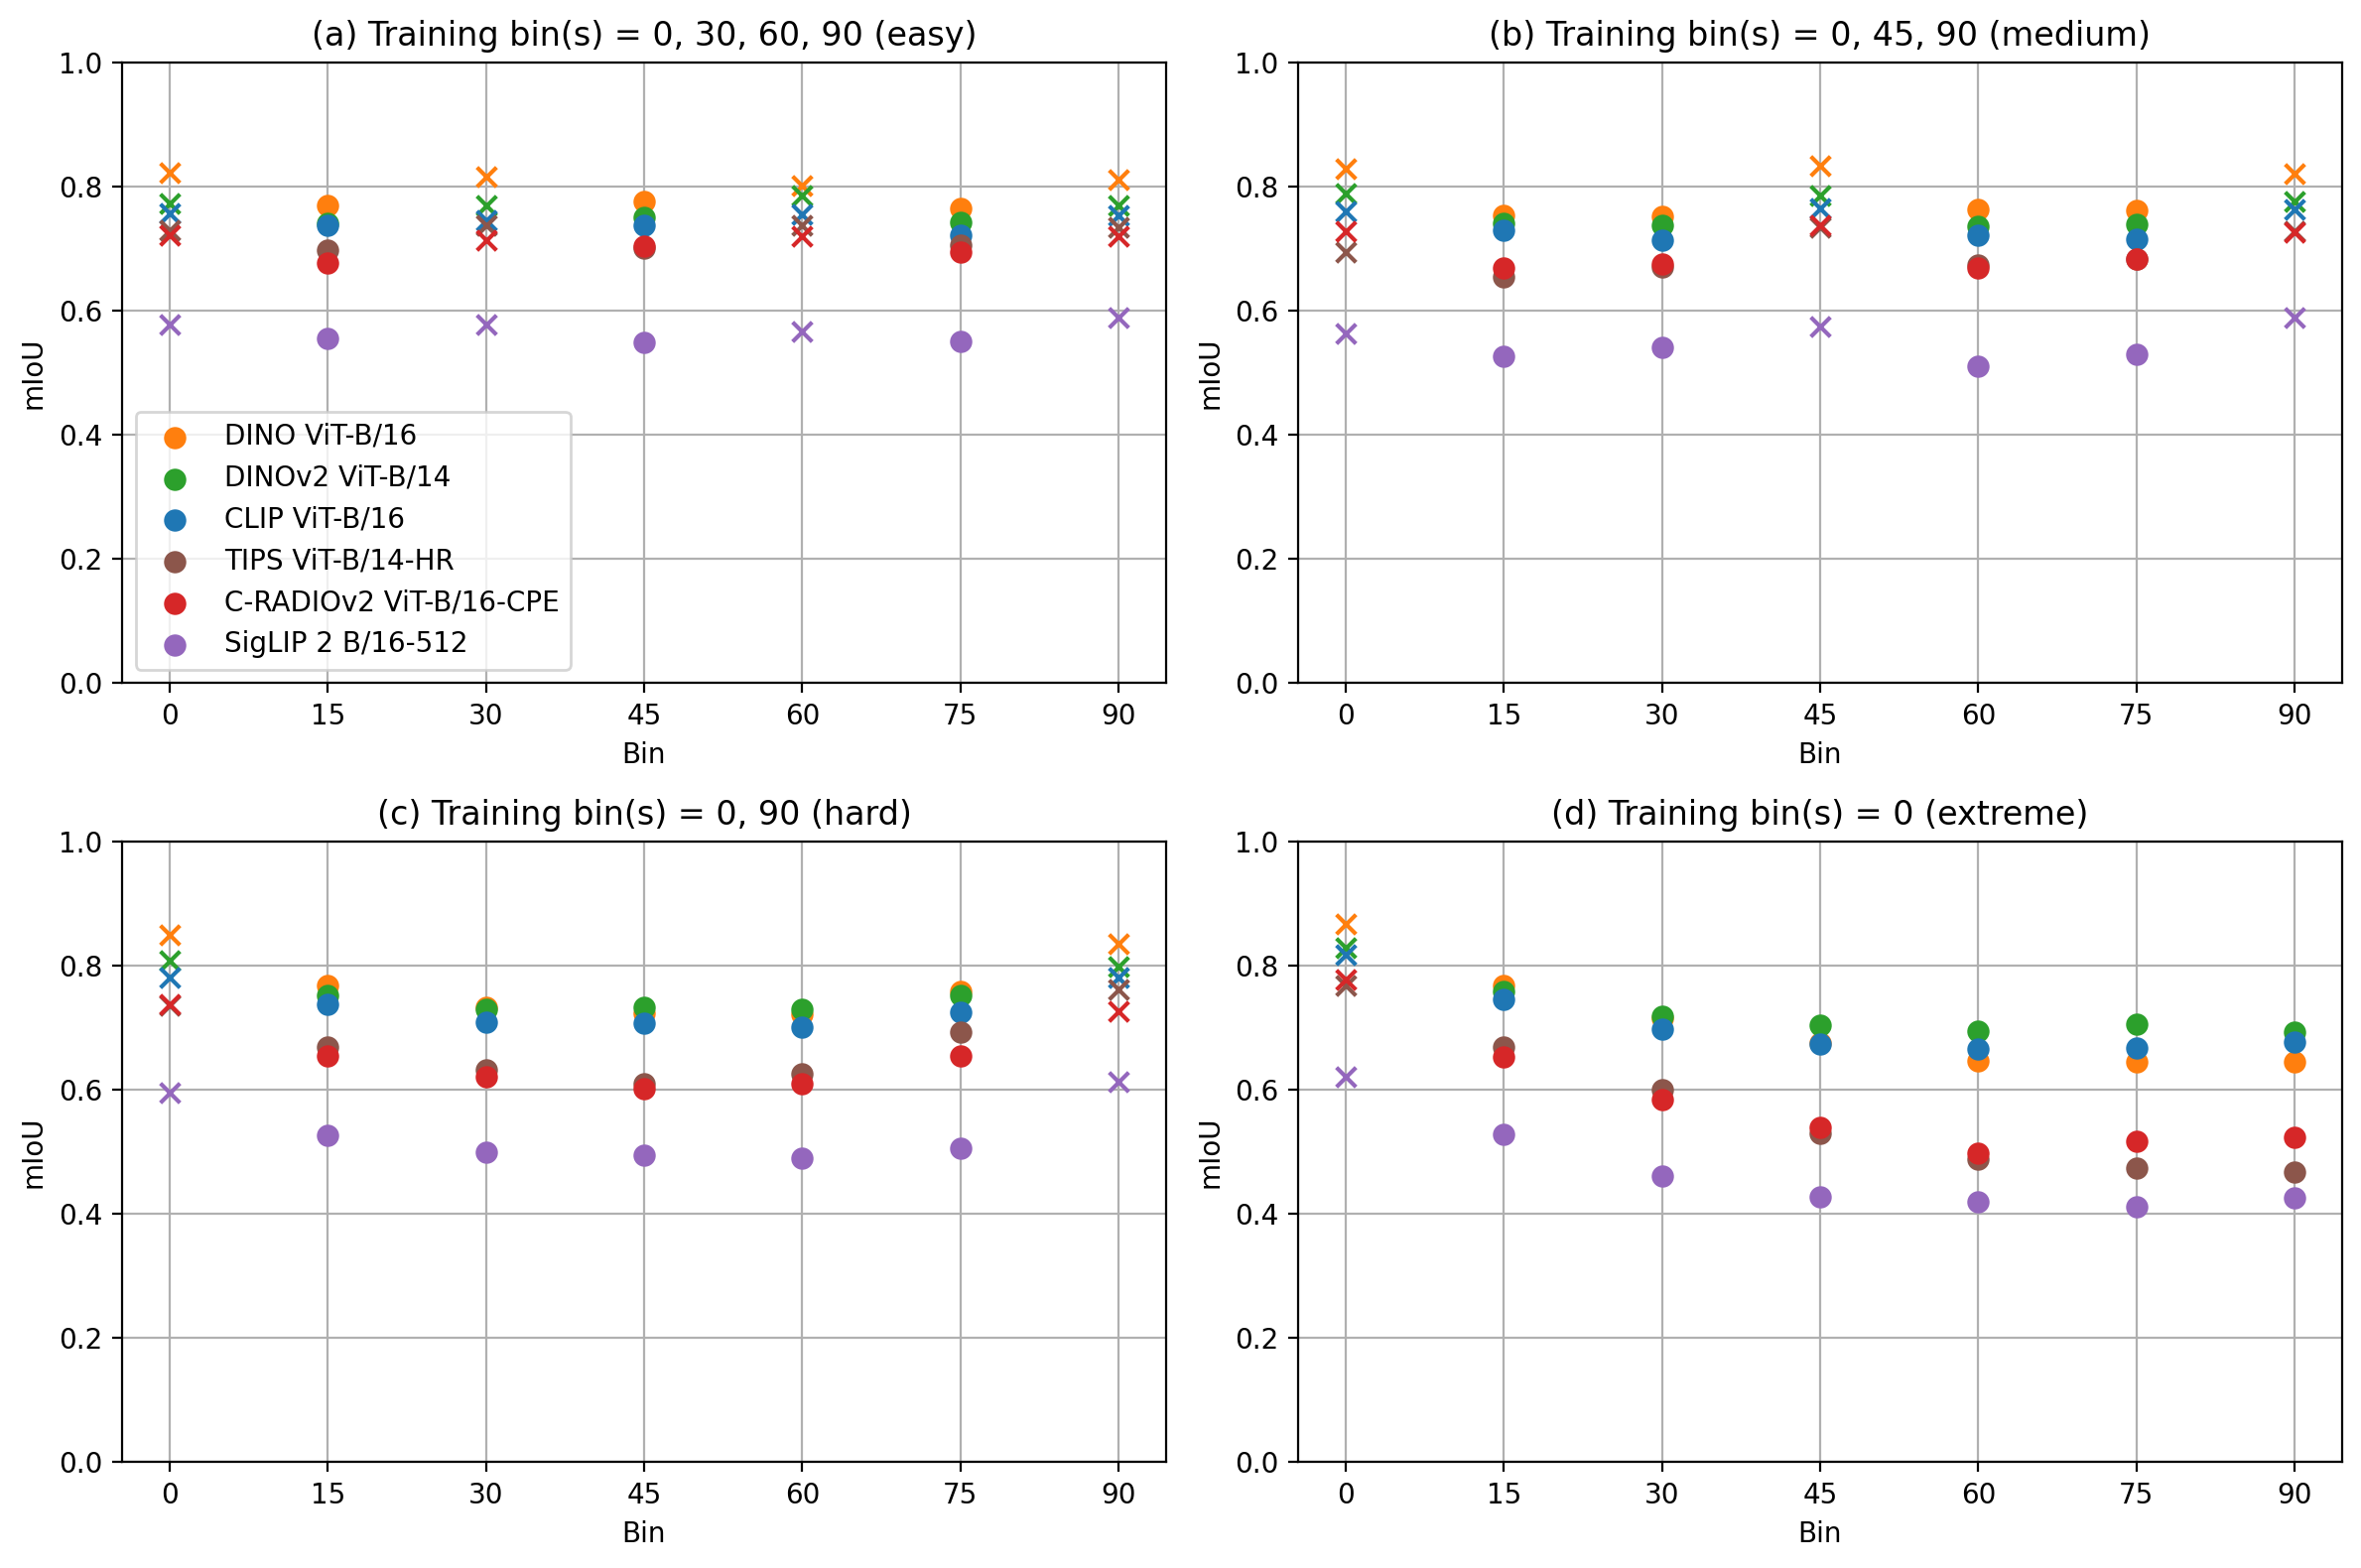

In [11]:
# plot figure with all classes included
# plot_exp_a(None, False, extratitle="all classes excl. bg")
plot_exp_a(None, True, extratitle="all classes")

# plot specific classes
plot_exp_a([113], False, extratitle=CLASS_TO_NAME[113])  # ceiling lamp

In [12]:
def plot_exp_a2(classes: None | list[int], include_bg: bool, extratitle: str):
    """
    Plot experiment A result as grouped bar histograms per class and model.
    """
    assert type(classes) in [list, type(None)], "classes must be a list or None"

    if classes is None:
        classes = list(CLASS_TO_INDEX.keys())
    else:
        assert all(c in CLASS_TO_INDEX for c in classes), "classes must be a subset of CLASS_TO_INDEX keys"

    if not include_bg:
        classes = [c for c in classes if c != 0]

    class_indices = [CLASS_TO_INDEX[c] for c in classes]
    class_labels = [CLASS_LABELS[c] for c in classes] if 'CLASS_LABELS' in globals() else [str(c) for c in classes]

    # print(class_labels)
    # class_indices = [class_indices[15]]
    # plt.subplots_adjust(wspace=0.3, hspace=0.4)  # increase subplot spacing

    fig, axes = plt.subplots(2, 2, figsize=(14, 8), dpi=200)
    axes = axes.flatten()

    bar_width = 0.15
    for i, (train_bins, difficulty) in enumerate(TRAIN_BINS_DIFFICULTY.items()):
        ax = axes[i]
        train_bins_set = set(map(int, train_bins.split("_")))
        bin_vals = sorted(set(DF["val_bin"]))

        x_pos = np.arange(len(bin_vals))  # One group per val_bin
        total_models = len(MODELS)

        for model_idx, (model, model_label) in enumerate(MODELS.items()):
            df = DF[(DF["model"] == model) & (DF["train_bins"] == train_bins)].sort_values("val_bin")
            if df.empty:
                print(f"No data for model {model} with train_bins {train_bins} and classes {classes}")
                continue

            # means = df[[f"jac{c}" for c in class_indices]].mean(axis=1).values
            # stds = df[[f"jac{c}" for c in class_indices]].std(axis=1).values

            # Offset x for grouped bars
            offset = (model_idx - total_models / 2) * bar_width + bar_width / 2
            x_offset = x_pos + offset

            # ax.bar(x_offset, means, width=bar_width, yerr=stds, label=model_label,
            #        color=COLORS[model], capsize=4, zorder=2)

            # df = df[[]]
            means = df[[f"jac{c}" for c in class_indices]].mean(axis=1).values

            
            # # means[5:10] = 0
            # print(len(means))
            # print(means)

            if i == 0:
                means[0] = 0
                means[2] = 0
                means[4] = 0
                means[6] = 0
            elif i == 1:
                means[0] = 0
                means[3] = 0
                means[6] = 0
            elif i == 2:
                means[0] = 0
                means[6] = 0
            elif i == 3:
                means[0] = 0

            ax.bar(x_offset, means, width=bar_width, label=model_label,
                   color=COLORS[model], capsize=4, zorder=2)

            means = df[[f"jac{c}" for c in class_indices]].mean(axis=1).values
            if i == 0:
                means[1] = 0
                means[3] = 0
                means[5] = 0
            elif i == 1:
                means[1] = 0
                means[2] = 0
                means[4] = 0
                means[5] = 0
            elif i == 2:
                means[1] = 0
                means[2] = 0
                means[3] = 0
                means[4] = 0
                means[5] = 0
            elif i == 3:
                means[6] = 0
                means[1] = 0
                means[2] = 0
                means[3] = 0
                means[4] = 0
                means[5] = 0
            ax.scatter(x_offset, means, marker='.', color=COLORS[model], s=50, zorder=3)

        ax.set_xticks(x_pos)
        ax.set_xticklabels([str(b) for b in bin_vals])
        ax.set_ylim(0, 1)
        ax.set_title(f"({string.ascii_letters[i]}) Train bin(s): {', '.join(train_bins.split('_'))} ({difficulty})")
        ax.set_xlabel("Validation Bin")
        ax.set_ylabel("mIoU")
        ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

    # axes[0].legend()
    axes[0].legend(loc="lower left", bbox_to_anchor=(0, 0))
    plt.suptitle(f"Experiment A Results — {extratitle}", fontsize=25, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


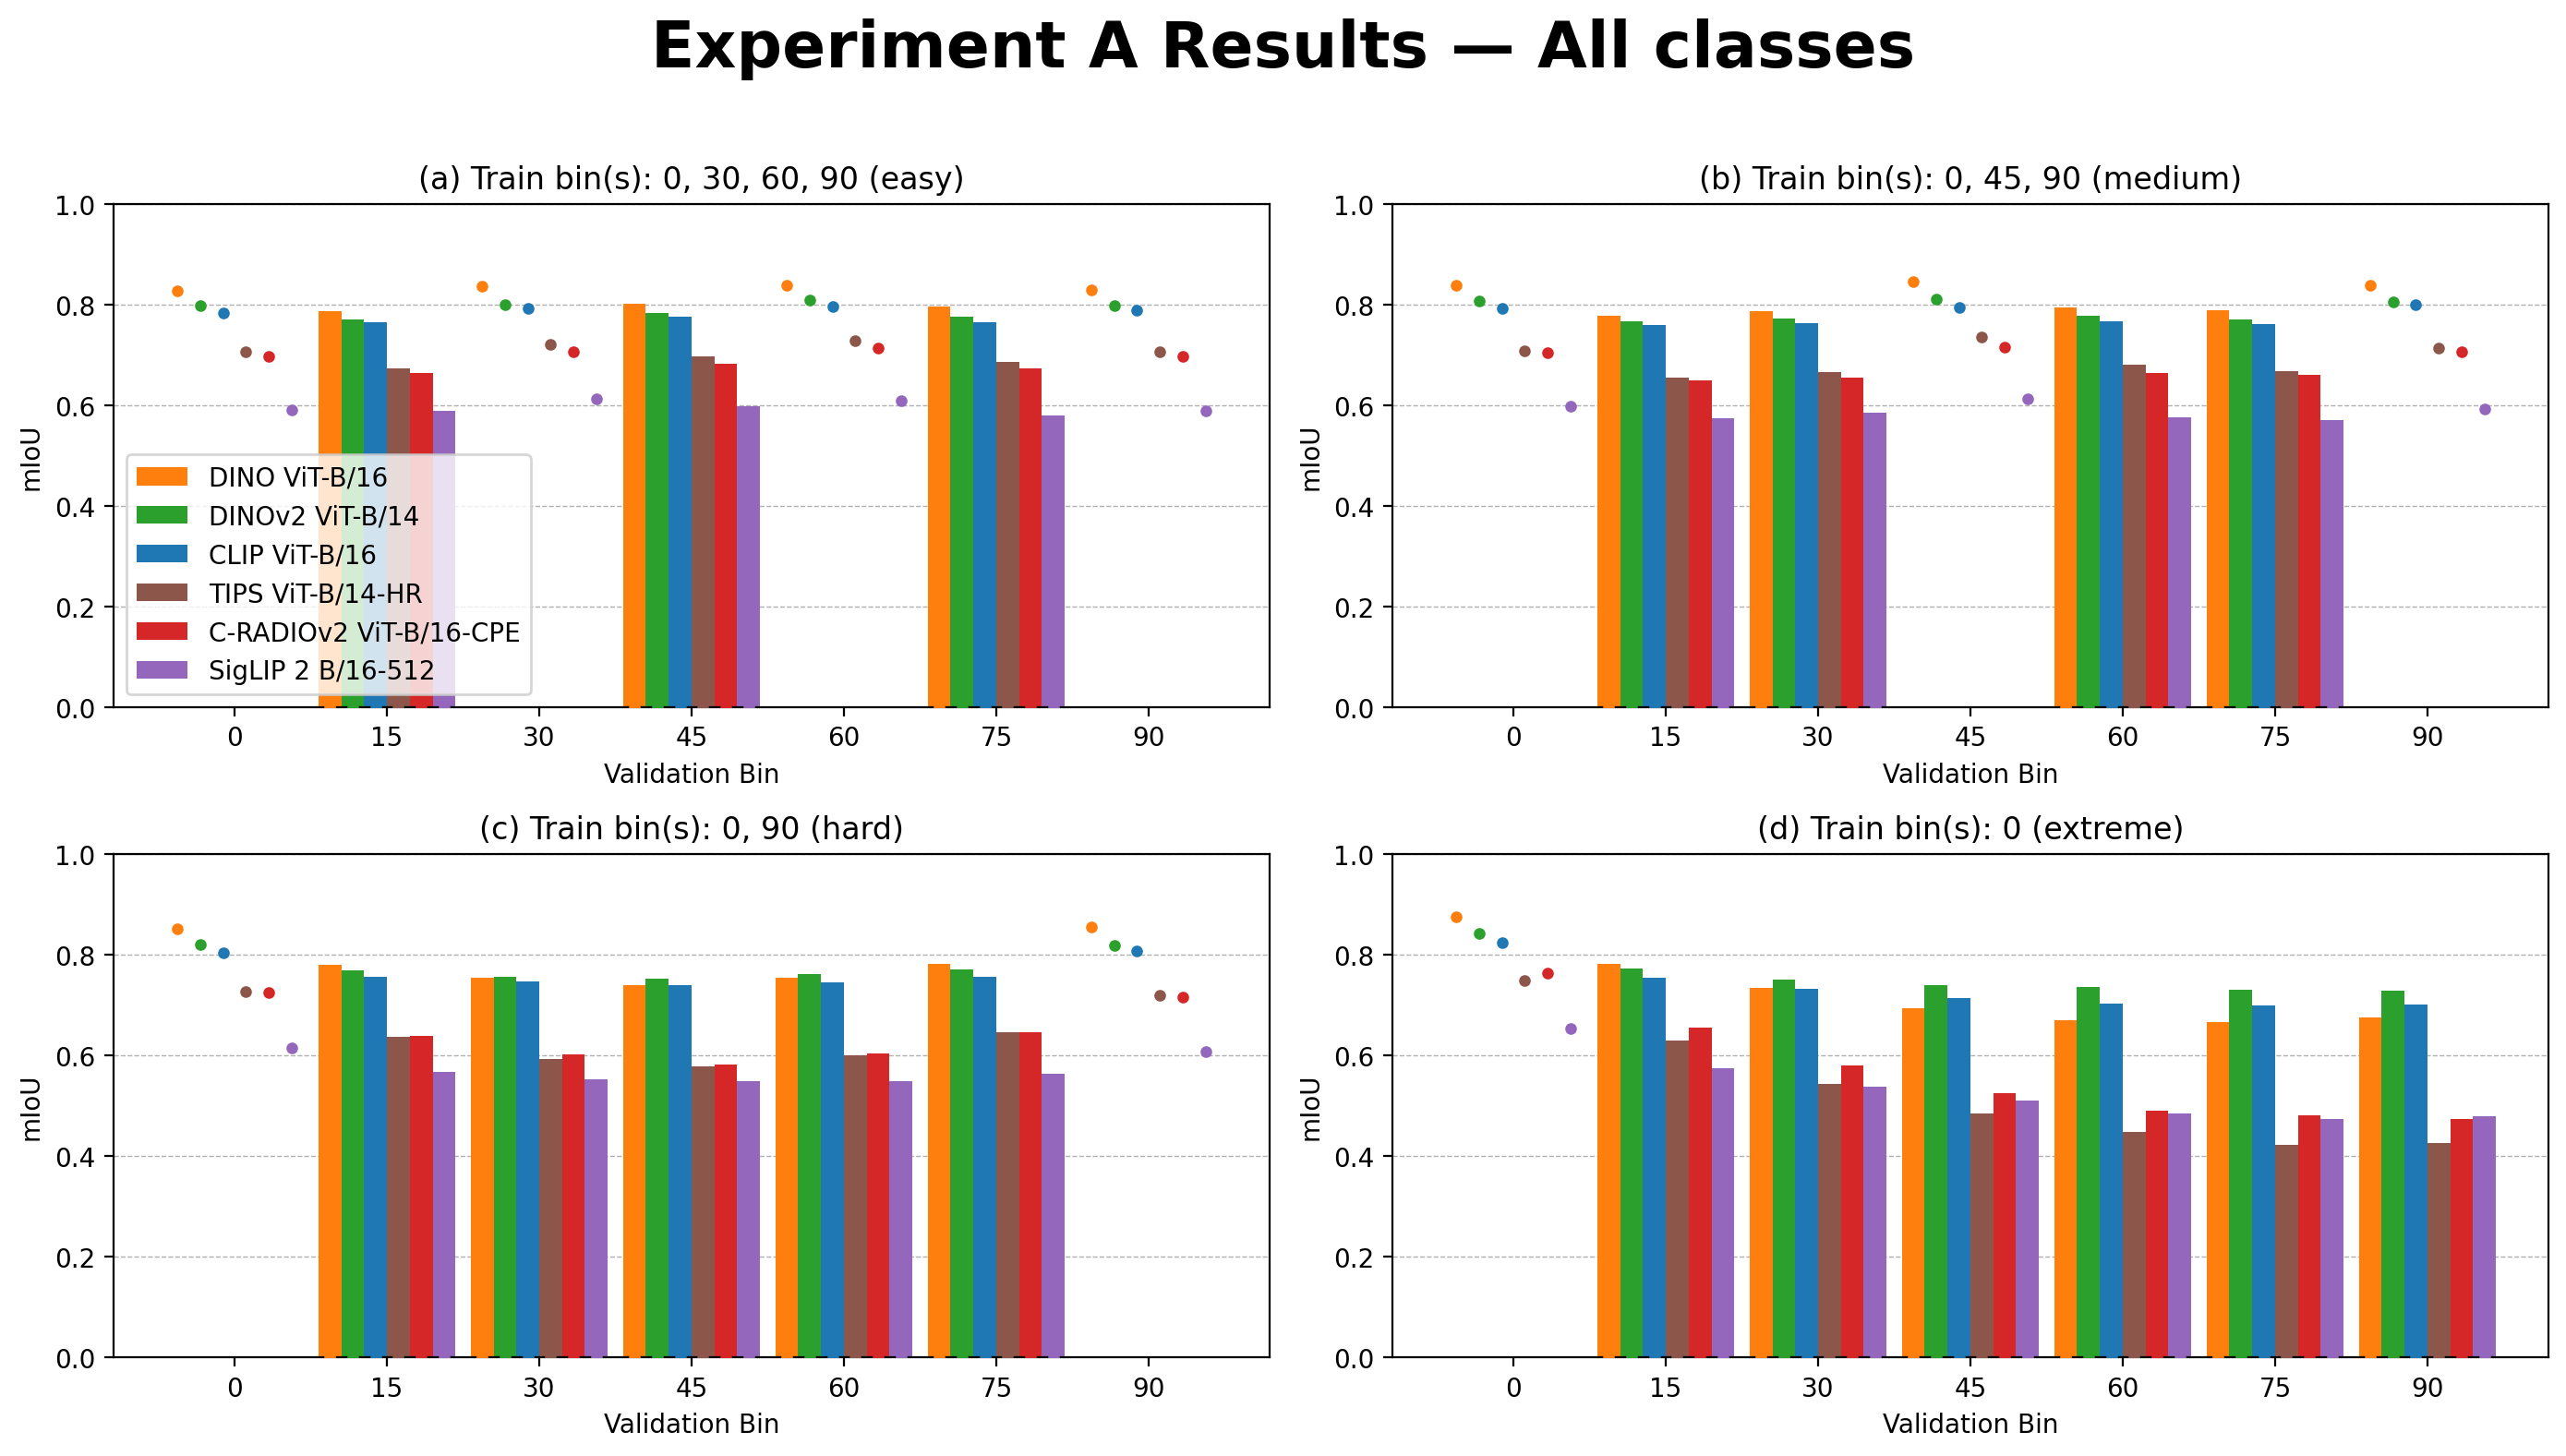

In [13]:
# plot figure with all classes included
# plot_exp_a(None, False, extratitle="all classes excl. bg")
plot_exp_a2(None, True, extratitle="All classes")

# plot specific classes
# plot_exp_a2([113], False, extratitle=CLASS_TO_NAME[113])  # ceiling lamp

In [14]:
import pandas as pd
from pathlib import Path

# Load your results CSV
csv_path = Path("../results/results_exp_a_500_sharding_batch4_workers8_dataparallel_memory1024000_new.csv")
df = pd.read_csv(csv_path)

# Define model name → log file prefix mapping
model_to_prefix = {
    "C-RADIOv2-B": "radio",
    "clip-vit-base-patch16": "clip",
    "dino_vitb16": "dino",
    "siglip2-base-patch16-512": "siglip2",
    "dinov2_vitb14": "dinov2",
    "tips-b14": "tips",
}

# Get all unique (job_id, model) pairs
unique_jobs = df[['job_id', 'model']].drop_duplicates()

# Function to extract JOB STATISTICS section
def print_job_statistics(job_id, model):
    prefix = model_to_prefix.get(model)
    if not prefix:
        print(f"⚠️ Skipping unknown model: {model}")
        return
    
    log_path = Path(f"../logs/exp_a_b/{prefix}.job_{job_id}.log")
    print(f"\n=== JOB STATISTICS for job_id: {job_id}, model: {model} ===")
    
    if not log_path.exists():
        print(f"⚠️ Log file not found: {log_path}")
        return

    with open(log_path, 'r') as f:
        lines = f.readlines()
        try:
            start_idx = next(i for i, line in enumerate(lines) if 'JOB STATISTICS' in line)
            for line in lines[start_idx:]:
                print(line, end='')  # already includes newline
        except StopIteration:
            print("⚠️ 'JOB STATISTICS' section not found in log.")

# Loop and print
memory = 1024000
print(f"The following JOB STATISTICS are for memory: {memory}")
for _, row in unique_jobs.iterrows():
    job_id = str(row['job_id'])
    model = row['model']
    print_job_statistics(job_id, model)


FileNotFoundError: [Errno 2] No such file or directory: '../results/results_exp_a_500_sharding_batch4_workers8_dataparallel_memory1024000_new.csv'

## Table

In [421]:
df = pd.read_csv(PATH)

# change train_bins to a list of integers
df["train_bins"] = df["train_bins"].apply(lambda x: list(map(int, x.split("_"))))

# if val_bin is in train_bins, set val_in_trained accordingly
df["val_in_trained"] = df.apply(lambda row: row["val_bin"] in row["train_bins"], axis=1)

# set difficulty column
df["difficulty"] = df["train_bins"].apply(lambda x: TRAIN_BINS_DIFFICULTY["_".join(map(str, x))])

# filter only untrained bins
df = df[~df["val_in_trained"]].copy()

df_exp_a = pd.DataFrame(columns=["model", "easy", "medium", "hard", "extreme"])

# for each model and difficulty, calculate the mean and std of jac_mean
for model in MODELS.keys():
    model_df = df[df["model"] == model]
    model_df.loc[:, "jac_mean"] = model_df[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
    model_df.loc[:, "jac_std"] = model_df[[f"jac{i}" for i in range(1, 16)]].std(axis=1)
    
    # calculate mean and std for each difficulty
    means = model_df.groupby("difficulty")["jac_mean"].mean()
    stds = model_df.groupby("difficulty")["jac_std"].mean()

    # create a row for the model
    row = {
        "model": MODELS[model],
        "easy": f"{means.get('easy', 0):.3f} ± {stds.get('easy', 0):.3f}",
        "medium": f"{means.get('medium', 0):.3f} ± {stds.get('medium', 0):.3f}",
        "hard": f"{means.get('hard', 0):.3f} ± {stds.get('hard', 0):.3f}",
        "extreme": f"{means.get('extreme', 0):.3f} ± {stds.get('extreme', 0):.3f}"
    }
    
    df_exp_a = pd.concat([df_exp_a, pd.DataFrame([row])], ignore_index=True)

df_exp_a

,model,easy,medium,hard,extreme
0,DINO ViT-B/16,0.782 ± 0.132,0.774 ± 0.137,0.748 ± 0.153,0.686 ± 0.171
1,DINOv2 ViT-B/14,0.763 ± 0.136,0.758 ± 0.139,0.748 ± 0.143,0.728 ± 0.154
2,CLIP ViT-B/16,0.755 ± 0.130,0.748 ± 0.134,0.734 ± 0.140,0.701 ± 0.149
3,TIPS ViT-B/14-HR,0.667 ± 0.137,0.647 ± 0.146,0.588 ± 0.162,0.462 ± 0.169
4,C-RADIOv2 ViT-B/16-CPE,0.653 ± 0.129,0.636 ± 0.132,0.592 ± 0.141,0.506 ± 0.150
5,SigLIP B/16-512,0.564 ± 0.150,0.551 ± 0.153,0.530 ± 0.157,0.481 ± 0.152


In [422]:
# required for to_latex
# !pip install jinja2

In [423]:
# give latex table
latex_table = df_exp_a.to_latex(index=False, escape=False, column_format='lcccc', 
                                  header=["Model", "Easy", "Medium", "Hard", "Extreme"])
print(latex_table)

\begin{tabular}{lcccc}
\toprule
Model & Easy & Medium & Hard & Extreme \\
\midrule
DINO ViT-B/16 & 0.782 ± 0.132 & 0.774 ± 0.137 & 0.748 ± 0.153 & 0.686 ± 0.171 \\
DINOv2 ViT-B/14 & 0.763 ± 0.136 & 0.758 ± 0.139 & 0.748 ± 0.143 & 0.728 ± 0.154 \\
CLIP ViT-B/16 & 0.755 ± 0.130 & 0.748 ± 0.134 & 0.734 ± 0.140 & 0.701 ± 0.149 \\
TIPS ViT-B/14-HR & 0.667 ± 0.137 & 0.647 ± 0.146 & 0.588 ± 0.162 & 0.462 ± 0.169 \\
C-RADIOv2 ViT-B/16-CPE & 0.653 ± 0.129 & 0.636 ± 0.132 & 0.592 ± 0.141 & 0.506 ± 0.150 \\
SigLIP B/16-512 & 0.564 ± 0.150 & 0.551 ± 0.153 & 0.530 ± 0.157 & 0.481 ± 0.152 \\
\bottomrule
\end{tabular}



# Experiment B

In [16]:
# PATH = "results_exp_a_500_sharding_batch4_workers8_dataparallel_memory320000.csv"
DF = pd.read_csv(PATH)
DF = DF[DF["train_bins"] == "0"]

DF.head(10)

,job_id,model,train_bins,val_bin,jac_mean,jac_std,jac0,jac1,jac2,jac3,...,jac10,jac11,jac12,jac13,jac14,jac15,d_model,batch_size,input_size,patch_size
98,12081378,clip-vit-base-patch16,0,0,0.824,0.090,0.976,0.879,0.888,0.841,...,0.817,0.883,0.773,0.893,0.880,0.912,768,4,512,16
99,12081378,clip-vit-base-patch16,0,15,0.755,0.139,0.970,0.837,0.836,0.735,...,0.746,0.863,0.574,0.884,0.861,0.899,768,4,512,16
100,12081378,clip-vit-base-patch16,0,30,0.733,0.150,0.969,0.827,0.819,0.695,...,0.697,0.855,0.526,0.880,0.854,0.894,768,4,512,16
101,12081378,clip-vit-base-patch16,0,45,0.714,0.155,0.969,0.811,0.779,0.666,...,0.674,0.841,0.499,0.859,0.857,0.898,768,4,512,16
102,12081378,clip-vit-base-patch16,0,60,0.704,0.157,0.969,0.796,0.770,0.653,...,0.665,0.835,0.528,0.838,0.859,0.895,768,4,512,16
103,12081378,clip-vit-base-patch16,0,75,0.700,0.160,0.969,0.792,0.782,0.652,...,0.667,0.838,0.535,0.845,0.860,0.892,768,4,512,16
104,12081378,clip-vit-base-patch16,0,90,0.702,0.160,0.969,0.787,0.785,0.660,...,0.677,0.847,0.486,0.860,0.858,0.890,768,4,512,16
112,12081380,dino_vitb16,0,0,0.876,0.075,0.984,0.914,0.936,0.897,...,0.867,0.930,0.863,0.929,0.924,0.944,768,4,512,16
113,12081380,dino_vitb16,0,15,0.783,0.143,0.977,0.862,0.865,0.752,...,0.767,0.901,0.558,0.908,0.902,0.931,768,4,512,16
114,12081380,dino_vitb16,0,30,0.734,0.171,0.974,0.814,0.816,0.658,...,0.715,0.851,0.468,0.880,0.893,0.926,768,4,512,16


In [17]:
def plot_exp_b(normalize=False):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

    if normalize:
        plt.scatter(0, 1, color="black", marker="x", zorder=5, label="Baseline performance")
        plot_title = "Experiment B results (normalized to 0-bin performance)"
        y_label = "Normalized mIoU"
    else:
        plot_title = "Experiment B results"
        y_label = "mIoU"

    for model in MODELS.keys():
        df = DF[DF["model"] == model].copy()
        df["jac_mean"] = df[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
        df["jac_std"] = df[[f"jac{i}" for i in range(1, 16)]].std(axis=1)

        if not normalize:
            # plot the 0-bin performance
            df0 = df[df["val_bin"] == 0]
            x_values = df0["val_bin"]
            y_values = df0["jac_mean"]
            plt.scatter(x_values, y_values, color=COLORS[model], marker="x", s=100, zorder=5)

        # plot the other validation bins [15, ..., 90]
        if normalize:
            # get bin=0 performance
            df0 = df[df["val_bin"] == 0]
            model_0_score = df0["jac_mean"].values[0]

            df1590 = df[df["val_bin"] != 0].copy()
            df1590["jac_norm"] = df1590["jac_mean"] / model_0_score
            x_values = df1590["val_bin"]
            y_values = df1590["jac_norm"]
        else:
            df1590 = df[df["val_bin"] != 0]
            x_values = df1590["val_bin"]
            y_values = df1590["jac_mean"].values

        plt.plot(x_values, y_values, label=MODELS[model], color=COLORS[model])

    plt.xlabel("Bin")
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.xticks(XTICKS)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()


## Plots

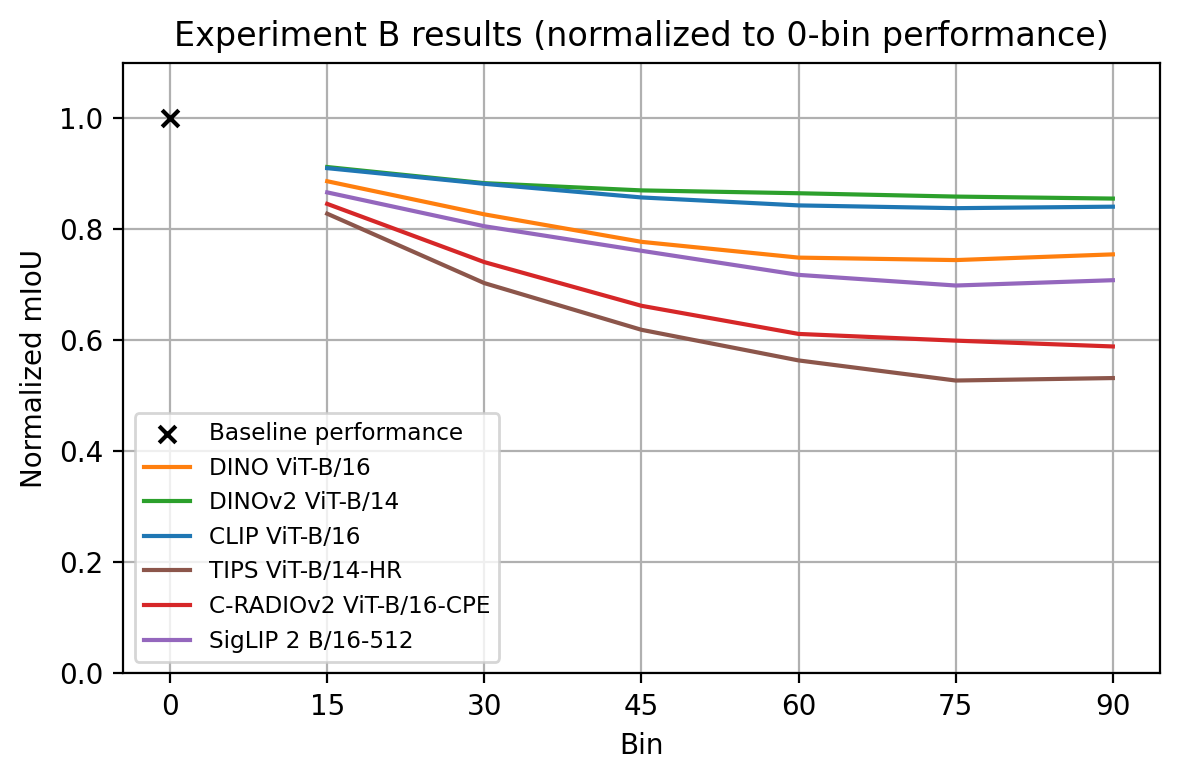

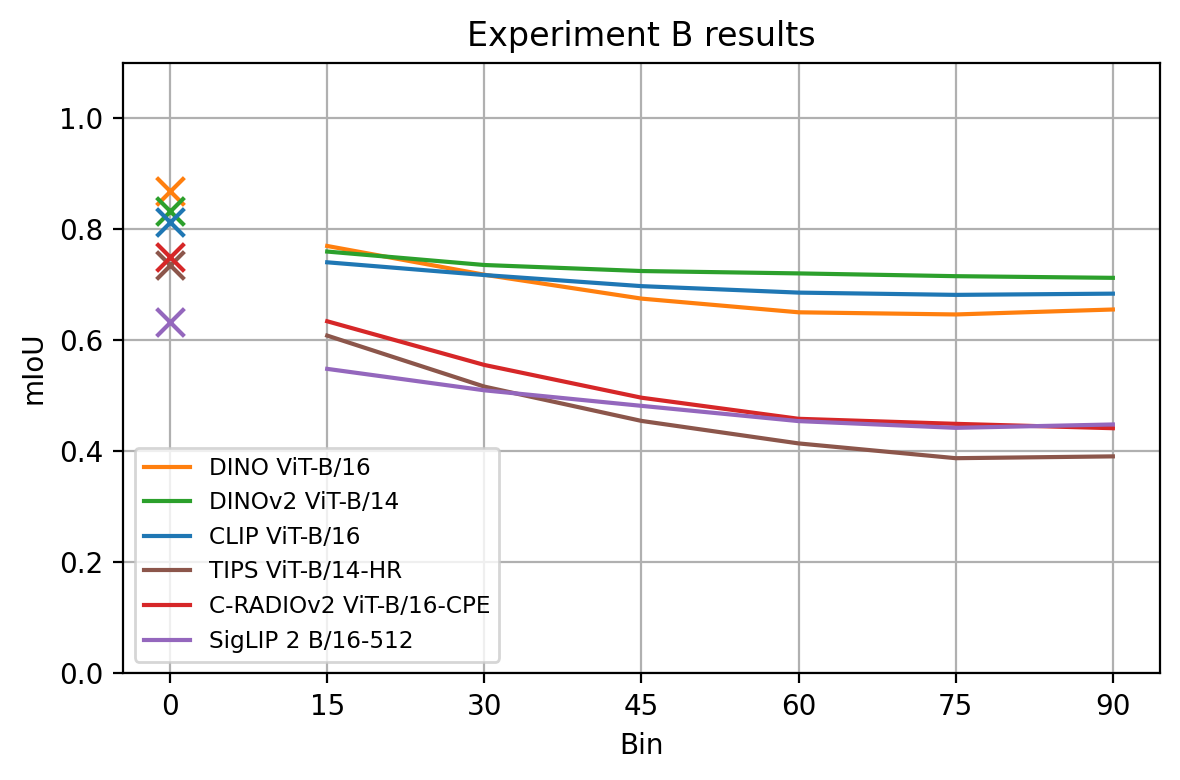

In [18]:
plot_exp_b(normalize=True)
plot_exp_b(normalize=False)

## Table

In [ ]:
DF = pd.read_csv(PATH)
DF.loc[:, "jac_mean"] = DF[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
DF.loc[:, "jac_std"] = DF[[f"jac{i}" for i in range(1, 16)]].std(axis=1)
DF = DF[DF["train_bins"] == "0"]  # extreme difficulty

test_df = None

threshold = 0.05

for model in MODELS.keys():
    df = DF[DF["model"] == model].copy()

    # get bin=0 performance
    df0 = df[df["val_bin"] == 0]
    model_0_score = df0["jac_mean"].values[0]

    df["jac_norm"] = df["jac_mean"] / model_0_score

    # jac_mean_prev is jac_mean but shifted down by one row
    df["jac_norm_prev"] = df["jac_norm"].shift(1)
    # delta is difference between jac norm and shifted jac norm
    df["delta"] = df["jac_norm"] - df["jac_norm_prev"]
    df = df[df["val_bin"] != 0]

    # concat
    if test_df is None:
        test_df = df.copy()
    else:
        test_df = pd.concat([test_df, df], ignore_index=True)

test_df

# To find a breaking point: check the last column called delta, compare the delta with the threshold
# The first delta exceeding the treshold is the breaking point

,job_id,model,train_bins,val_bin,jac_mean,jac_std,jac0,jac1,jac2,jac3,...,jac13,jac14,jac15,d_model,batch_size,input_size,patch_size,jac_norm,jac_norm_prev,delta
0,12081380,dino_vitb16,0,15,0.769867,0.142957,0.977,0.862,0.865,0.752,...,0.908,0.902,0.931,768,4,512,16,0.886467,1.000000,-0.113533
1,12081380,dino_vitb16,0,30,0.718067,0.170699,0.974,0.814,0.816,0.658,...,0.880,0.893,0.926,768,4,512,16,0.826821,0.886467,-0.059645
2,12081380,dino_vitb16,0,45,0.675067,0.182559,0.973,0.777,0.745,0.569,...,0.846,0.891,0.931,768,4,512,16,0.777309,0.826821,-0.049513
3,12081380,dino_vitb16,0,60,0.650400,0.179190,0.974,0.744,0.730,0.517,...,0.812,0.885,0.929,768,4,512,16,0.748906,0.777309,-0.028403
4,12081380,dino_vitb16,0,75,0.646533,0.175581,0.973,0.739,0.735,0.518,...,0.820,0.886,0.924,768,4,512,16,0.744454,0.748906,-0.004452
5,12081380,dino_vitb16,0,90,0.655467,0.173091,0.973,0.751,0.734,0.565,...,0.849,0.887,0.923,768,4,512,16,0.754740,0.744454,0.010286
6,12081381,dinov2_vitb14,0,15,0.759800,0.141287,0.971,0.864,0.856,0.782,...,0.902,0.863,0.908,768,4,504,14,0.912052,1.000000,-0.087948
7,12081381,dinov2_vitb14,0,30,0.735600,0.153034,0.969,0.848,0.831,0.732,...,0.889,0.853,0.903,768,4,504,14,0.883003,0.912052,-0.029049
8,12081381,dinov2_vitb14,0,45,0.724733,0.157607,0.968,0.837,0.797,0.730,...,0.881,0.855,0.907,768,4,504,14,0.869958,0.883003,-0.013044
9,12081381,dinov2_vitb14,0,60,0.720467,0.156787,0.969,0.827,0.793,0.723,...,0.866,0.849,0.906,768,4,504,14,0.864837,0.869958,-0.005122
